In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

Research agent

In [2]:
from langchain_tavily import TavilySearch

# Search tool
web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke('who is the president of guinea-bissau?')

print(web_search_results['results'][0]['content'])

Umaro Mokhtar Sissoco Embaló (born 23 September 1972) is a Bissau-Guinean politician serving as the president of Guinea-Bissau since February 2020.


In [3]:
web_search_results

{'query': 'who is the president of guinea-bissau?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/Umaro_Sissoco_Embal%C3%B3',
   'title': 'Umaro Sissoco Embaló - Wikipedia',
   'content': 'Umaro Mokhtar Sissoco Embaló (born 23 September 1972) is a Bissau-Guinean politician serving as the president of Guinea-Bissau since February 2020.',
   'score': 0.91362286,
   'raw_content': None},
  {'url': 'https://en.wikipedia.org/wiki/List_of_presidents_of_Guinea-Bissau',
   'title': 'List of presidents of Guinea-Bissau - Wikipedia',
   'content': 'The current holder of the office is Umaro Sissoco Embaló, who took office on 27 February 2020 after being elected in the 2019 presidential election. Contents.',
   'score': 0.9061314,
   'raw_content': None},
  {'url': 'https://www.atlanticcouncil.org/blogs/new-atlanticist/guinea-bissaus-president-on-his-meeting-with-trump-relations-with-russia-and-china-and-whether-he-will-accept-us-

In [4]:
# Retriever
from utils import load_docs, split_code, create_retriever # defined in utils.py file
from langchain_text_splitters import Language
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

from langchain_core.vectorstores import InMemoryVectorStore
from langchain_ollama import OllamaEmbeddings

SOURCE_CODE_PATH = './data/labeler-starter-kit-bsky-main/src'
FILE_EXTS = [".ts"]
LANG = Language.TS

def create_vector_store(src_path, file_extensions, lang):
    """Searches information from .ts documents stored in memory vector DB"""
    docs = load_docs(src_path, file_extensions)
    split_docs = split_code(docs, lang)
    embeddings = OllamaEmbeddings(model='llama3.2')
    
    vector_store = InMemoryVectorStore(embeddings)
    _ = vector_store.add_documents(split_docs)
    return vector_store

vs = create_vector_store(SOURCE_CODE_PATH, FILE_EXTS, LANG)

from langchain_core.tools import tool

@tool(response_format='content_and_artifact')
def retrieve_from_local(query):
    """Retrieve information related to a query"""
    retrieved_docs = vs.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [5]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model='openai:gpt-4.1',
    tools=[web_search, retrieve_from_local],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT generate any code\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name='research_agent'
)

Pretty-print functionality

In [6]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [7]:
# Test
for chunk in research_agent.stream(
    {'messages': [{'role': 'user', 'content': 'who is the president of guinea-bissau?'}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_TtFVBwfIbuPs1uFZKZHACTwO)
 Call ID: call_TtFVBwfIbuPs1uFZKZHACTwO
  Args:
    query: current president of Guinea-Bissau


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "current president of Guinea-Bissau", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.consuladoguineabissaumalaga.com/en/The-President/", "title": "The President", "content": "The current President of the Republic of Guinea-Bissau is His Excellency General Umaro Sissoco Embalo. President Umaro is a political scientist,", "score": 0.94726914, "raw_content": null}, {"url": "https://en.wikipedia.org/wiki/List_of_presidents_of_Guinea-Bissau", "title": "List of presidents of Guinea-Bissau - Wikipedia", "content": "There have been six

Code Generation Agent

In [8]:
from pydantic import BaseModel, Field

class Code(BaseModel):
    """Schema for code solutions from the coding assistant"""
    prefix: str = Field(description='Description of the problem and approach')
    imports: str = Field(description='Code Block import statements')
    code: str = Field(description='Code block not including import statements')

In [9]:
# Create code generation chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from data.prompts import CODE_GEN_SYSTEM
code_system_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', CODE_GEN_SYSTEM),
        ('placeholder', '{messages}')
    ]
)

llm = ChatOpenAI(model='gpt-4.1')
code_agent_chain = code_system_prompt | llm.with_structured_output(Code)

In [10]:
from langchain_core.messages import HumanMessage

res = code_agent_chain.invoke(
    {'messages':[HumanMessage(content='Create a function that computes the fibonacci sequence')]}
    )

In [11]:
print(res)

prefix='This solution defines a TypeScript function to compute the Fibonacci sequence up to a specified number of elements. It uses an iterative approach for performance and clarity. The function returns an array containing the sequence.' imports='// No external imports required' code='/**\n * Computes the Fibonacci sequence up to a given length.\n * @param n Number of Fibonacci numbers to compute (n >= 0)\n * @returns Array of Fibonacci numbers\n */\nexport function fibonacciSequence(n: number): number[] {\n  if (n <= 0) return [];\n  if (n === 1) return [0];\n  const sequence: number[] = [0, 1];\n  for (let i = 2; i < n; i++) {\n    sequence.push(sequence[i - 1] + sequence[i - 2]);\n  }\n  return sequence;\n}\n\n// Example usage:\n// fibonacciSequence(7) => [0, 1, 1, 2, 3, 5, 8]'


In [12]:
def generate_code(query):
    """Function to call the code generation LLM chain"""
    code_solution = code_agent_chain.invoke({'messages':[HumanMessage(content=query)]})
    return code_solution

In [13]:
coding_agent = create_react_agent(
    model='openai:gpt-4.1',
    tools=[generate_code],
    prompt=(
        "You are a coding agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with coding-related tasks in TypeScript\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name='coding_agent'
)

In [14]:
for chunk in coding_agent.stream(
    {'messages': [{'role': 'user', 'content': 'Create a function that computes the fibonacci sequence'}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: coding_agent
Tool Calls:
  generate_code (call_y5NtxUnDPcQr0d0aOpaPxYec)
 Call ID: call_y5NtxUnDPcQr0d0aOpaPxYec
  Args:
    query: Create a TypeScript function that computes the Fibonacci sequence


Update from node tools:


================================= Tool Message =================================
Name: generate_code

prefix='This solution defines a simple TypeScript function to compute the nth Fibonacci number. It uses an iterative approach for efficiency and includes type annotations. The function throws an error for invalid input (negative numbers).' imports='// No imports needed for this example.' code="/**\n * Computes the nth Fibonacci number (0-indexed).\n * @param n - Index in the Fibonacci sequence (must be >= 0)\n * @returns The nth Fibonacci number\n */\nexport function fibonacci(n: number): number {\n  if (!Number.isInteger(n) || n < 0) {\n    throw new E

### Supervisor agent

In [15]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model('openai:gpt-4.1'),
    agents=[research_agent, coding_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a coding agent. Assign coding-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode='full_history'
).compile()

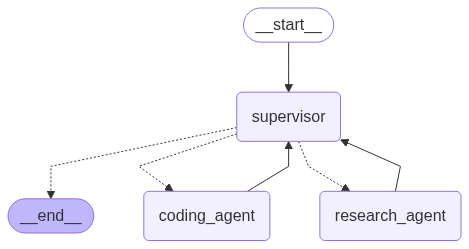

In [16]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))